In [ ]:
import torch
from torch import nn
import torch.optim as optim
from torchtext.legacy.data import Field,BucketIterator,TabularDataset,Dataset,Example
import numpy as np
import pandas as pd
import spacy
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns 
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from torchsummary import summary


In [ ]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.0 MB 6.6 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
spacy_en = spacy.load("en_core_web_sm")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
main_df=pd.read_csv("/content/drive/MyDrive/data/train.csv")

In [ ]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20068 entries, 0 to 20067
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_name         20067 non-null  object
 1   user_location     15860 non-null  object
 2   user_description  18685 non-null  object
 3   user_created      20068 non-null  object
 4   user_followers    20068 non-null  int64 
 5   user_friends      20068 non-null  int64 
 6   user_favourites   20068 non-null  int64 
 7   user_verified     20068 non-null  bool  
 8   date              20068 non-null  object
 9   text              20068 non-null  object
 10  hashtags          15771 non-null  object
 11  source            20068 non-null  object
 12  is_retweet        20068 non-null  bool  
 13  Sentiment         20068 non-null  object
dtypes: bool(2), int64(3), object(9)
memory usage: 1.9+ MB


In [ ]:
#We can see that the the intially they arent many missing rows and values

In [ ]:
main_df.columns

Index(['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'is_retweet', 'Sentiment'],
      dtype='object')

In [ ]:
main_df["Sentiment"].value_counts()

Positive    9513
Neutral     6982
Negative    3573
Name: Sentiment, dtype: int64

In [ ]:
main_df["Sentiment"].head()

0     Neutral
1     Neutral
2    Positive
3    Negative
4    Positive
Name: Sentiment, dtype: object

In [ ]:
def rename_labels(x):
  if x=="Positive":
    return 0
  elif x== "Neutral":
    return 1
  else:
    return 2

In [ ]:
main_df["Sentiment"]=main_df["Sentiment"].apply(lambda x : rename_labels(x))

In [ ]:
#there seems to be slight imbalance in the dataset but we proceed with this 

In [ ]:
#our main goal this project will be predicting rating based on the text and title 

In [ ]:
df=main_df.copy()

In [ ]:
df=df.drop(['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'hashtags', 'source', 'is_retweet',],axis=1)

In [ ]:
df.head()

,text,Sentiment
0,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,1
1,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,1
2,Go watch “The Social Dilemma” on Netflix!\n\nI...,0
3,I watched #TheSocialDilemma last night. I’m sc...,2
4,The problem of me being on my phone most the t...,0


In [ ]:
# lets look at the tweets length now 

In [ ]:
def text_len(x):
    return len(x.split(" "))

In [ ]:
text_len("Cristiano Ronaldo is the greatest of all time")

8

In [ ]:
df["textlen"]=df["text"].apply(lambda x : text_len(x))

In [ ]:
#now that we have the len of these texts we shall now inspect th column

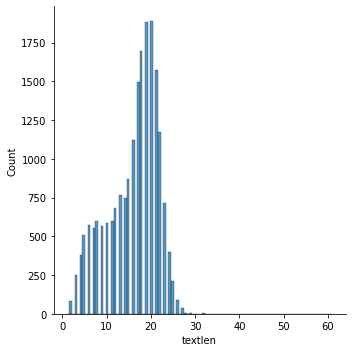

In [ ]:
sns.displot(df["textlen"])

In [ ]:
#We can see that most of the tweets are between 0-50.

In [ ]:
df["textlen"].max()

61

In [ ]:
df["textlen"].min()

1

In [ ]:
df[df["textlen"]>30].shape[0] 

8

In [ ]:
df=df.drop(["textlen"],axis=1)

In [ ]:
# to clean data
def normalise_text (text):
    text = text.str.lower() # lowercase
    text = text.str.replace(r"\#","") # replaces hashtags
    text = text.str.replace(r"http\S+","URL")  # remove URL addresses
    text = text.str.replace(r"@","")
    text = text.str.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
    text = text.str.replace("\s{2,}", " ")
    return text

In [ ]:
df["text"]=normalise_text(df["text"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
df['text'].head()

0    musicmadmarc socialdilemma netflix facebook i'...
1    musicmadmarc socialdilemma netflix facebook ha...
2    go watch the social dilemma on netflix! it s t...
3    i watched thesocialdilemma last night i m scar...
4    the problem of me being on my phone most the t...
Name: text, dtype: object

### Splitting the data 

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_df,valid_df=train_test_split(df,test_size=0.10,stratify=df["Sentiment"])

In [ ]:
train_df.shape

(18061, 2)

In [ ]:
valid_df.shape

(2007, 2)

In [ ]:
train_df.head()

,text,Sentiment
4782,watch thesocialdilemma seems silly to say that...,2
8131,everyone should watch thesocialdilemma it s sc...,2
16317,go watch thesocialdilemma good documentary,0
2034,thesocialdilemma a must watch documentary for ...,1
1667,okay but watching thesocialdilemma is terrifyi...,2


In [ ]:
valid_df.head()

,text,Sentiment
10568,being on social media is choice don t blame th...,0
8674,i remember taking a unit on new media amp we'd...,0
11494,watched thesocialdilemma earlier i am so happy...,0
1599,thesocialdilemma i turned off notifications fo...,0
14046,i watched thesocialdilemma and got a bit upset...,0


In [ ]:
SEED = 42

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Building vocabulary from the dataset

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
def tokenize_english(text):
    return [token.text for token in spacy_en.tokenizer(text)]

In [ ]:
LABEL= Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
TEXT = Field(tokenize=tokenize_english, lower=True, include_lengths=True,batch_first=True)

In [ ]:
class DataFrameDataset(Dataset):

    def __init__(self, df, fields, is_test=False, **kwargs):
        examples = []
        for i, row in df.iterrows():
            label = row.Sentiment if not is_test else None
            text = row.text
            examples.append(Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    @classmethod
    def splits(cls, fields, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)
        data_field = fields

        if train_df is not None:
            train_data = cls(train_df.copy(), data_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), data_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), data_field, True, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

In [ ]:
fields = [('text',TEXT), ('label',LABEL)]

train_ds,val_ds= DataFrameDataset.splits(fields, train_df=train_df, val_df=valid_df)

In [ ]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator = BucketIterator.splits(
    (train_ds, val_ds), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device,sort_key = lambda x: len(x.text))

In [ ]:
TEXT.build_vocab(train_ds, min_freq=3)

In [ ]:
print(f"Unique tokens in target (en) vocabulary: {len(TEXT.vocab)}")

Unique tokens in target (en) vocabulary: 4640


In [ ]:
#next(iter(train_iterator))

## BUILDING THE ARCHITECTURE OF THE MODEL

In [ ]:
class Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=n_layers,
                            bidirectional=True)
        self.fc1 = nn.Linear(2*hidden_dim,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 3)
        self.drop = nn.Dropout(p=0.2)
        
              
    def forward(self, text, text_len):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_len.to("cpu"),batch_first=True)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden = self.drop(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        output = self.fc1(hidden)
        
        output = (self.fc2(self.drop(output)))

        return output

In [ ]:
# Hyperparameters
num_epochs = 20
learning_rate = 0.0001
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 200
HIDDEN_DIM = 128
OUTPUT_DIM = 1
N_LAYERS = 2
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] # padding

In [ ]:
model = Model(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            PAD_IDX)

In [ ]:
model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
BATCH_SIZE=32

In [ ]:
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds =preds.argmax(axis=1)
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
# training function 
def train(model, iterator):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for j in iterator:
        text, text_lengths = j.text
        j.label=j.label.type(torch.LongTensor)
        j.label = j.label.to(device)
        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, j.label)
        acc = binary_accuracy(predictions, j.label)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator):
    
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            batch.label=batch.label.type(torch.LongTensor)
            batch.label=batch.label.to(device)
            predictions = model(text, text_lengths).squeeze(1)
            acc = binary_accuracy(predictions, batch.label)
            
            epoch_acc += acc.item()
        
    return epoch_acc / len(iterator)

In [ ]:
loss=[]
acc=[]
val_acc=[]

for epoch in range(num_epochs):
    
    train_loss, train_acc = train(model, train_iterator)
    valid_acc = evaluate(model, valid_iterator)
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Acc: {valid_acc*100:.2f}%')
    
    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)